<a href="https://colab.research.google.com/github/CatIsOutOfTheBag/Probability_and_Statistics/blob/main/A_B_tests_continious_variable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Основная проблема непрерывной переменной - неизвестное распределение

Конечно, две выборки можно стравнить бутстрапом. Но с помощью него нельзя запланировть эксперимент.

Посмотрим при нормальном распределении

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')

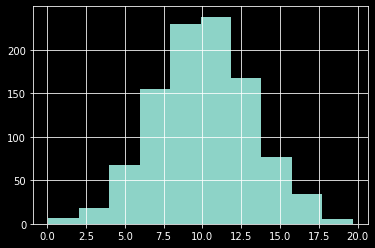

In [ ]:
# сгенерируем два распределения
# нормальное
pd.Series(np.random.normal(10,3,size=1000)).hist() # среднее/ст.отклонение/азмер выборки

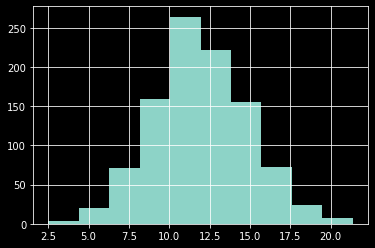

In [ ]:
# допустим нужно задетектить, что среднее увеличилось на 2 (от 10 до 12)
# например, сколько времени человек в средем проводит на сайте, на новом лендинге
pd.Series(np.random.normal(12,3,size=1000)).hist() # среднее/ст.отклонение/азмер выборки

In [ ]:
# как понять , какой нужен размер выборки, чтобы задетектить минимальный эффект (mde) = 2?
# нужно подобрать размер выборки при мощности 80% и уровне значимости 5%

from scipy.stats import ttest_ind
from tqdm.notebook import tqdm

baseline = 10
mde = 2
sample_size = 36
result = []
n = 10000

for _ in tqdm(range(n)):
  a = np.random.normal(baseline,3,size = sample_size)
  b = np.random.normal(baseline + mde,3,size = sample_size)
  # используем T-test = Student Test
  # условие необходимое для T-test:
  # - нормальность распределения выборочного среднего (работает цпт)
  # т.е. даже если у нас не нормальное распределение, но выборка достаточно большая,
  # чтобы выборочное среднее сходилось к нормальному распределению, можно применять T-test

  # T-test проводим из предположения, что дисперсии не равны = тест Уэлча
  _, pval = ttest_ind(a,b,equal_var=False)
  result.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
t = pd.Series(result)

In [ ]:
(t < 0.05).mean() # получаем мощность

0.7919

Первый способ проверить пригодность теста

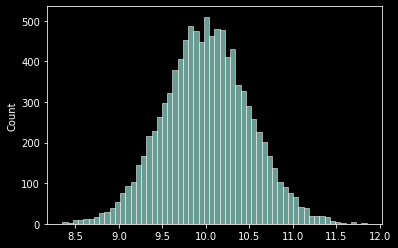

In [ ]:
# Проверим пригодность T-теста:
# действительно ли при выборке в 36 выборочное среднее распределено нормально
# забутстрапим (замонтекарлим) это среднее
import seaborn as sns

sns.histplot([np.random.normal(10,3,size = 36).mean() for _ in range(10000)])

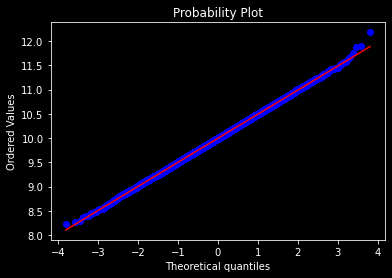

In [ ]:
# для проверки на нормальность(и не только) используем qqplot
import pylab
import scipy.stats as stats

t = [np.random.normal(10,3,size = 36).mean() for _ in range(10000)]
stats.probplot(t, dist='norm', plot=pylab) # что с ч/ем сравниваем (t c 'norm')

pylab.show()

Второй способ проверить пригодность теста

In [ ]:
# генерируем выборки из двух одинаковых выборок
# p_value должен быть распределен равномерно

baseline = 10
mde = 2
sample_size = 36
result = []
n = 10000

for _ in tqdm(range(n)):
  a = np.random.normal(baseline,3,size = sample_size)
  b = np.random.normal(baseline,3,size = sample_size)
  _, pval = ttest_ind(a,b,equal_var=False)
  result.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

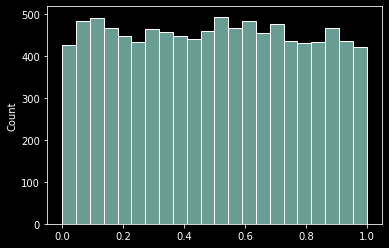

In [ ]:
sns.histplot(result)

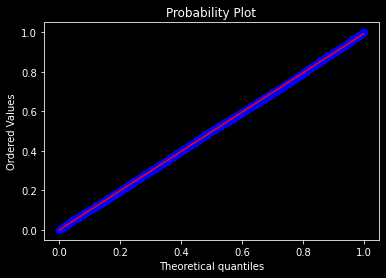

In [ ]:
t = pd.Series(result)
stats.probplot(t, dist='uniform', plot=pylab);

Третий способ проверить пригодность теста

In [ ]:
# Действительно ли альфа соответствует false positive
(t < 0.05).mean()

0.0471

Как проверить, что можно применять T-test:
- выборочное среднее распределено нормально (bootstrap+qq)
- p_value для выборок из одного распределения имеем равномерное распределение (bootstrap+qq)
- теоретический false positive == практическому false positive

Тогда можно рассчитать размер выборки подбором

Или математически

In [ ]:
# Математический рассчет
import statsmodels.stats.api as sms
effect_size = (12-10)/3 # mde/std_deviation
sms.TTestIndPower().solve_power(effect_size, power=0.80, alpha=0.05, ratio=1)
# видим наш подобранный размер выборки

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


36.305687896793614

Посмотрим ситуацию, когда распределение не нормальное

Например, логнормальное

In [ ]:
a = np.random.lognormal(mean=5, sigma=2, size=(10000,))
b = np.random.lognormal(mean=5.04, sigma=2, size=(10000,))
# здесь среднее - это среднее нормального распределения, до логарифма

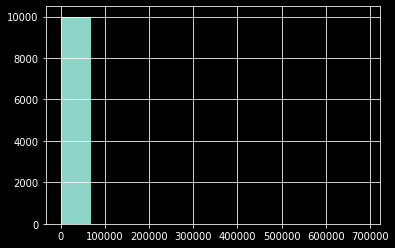

In [ ]:
pd.Series(a).hist()

In [ ]:
#  в таком жирнохвостовом распределении очень сложно найти истинное среднее
# сделать это можно с помощью бутстрапа
t = [(np.random.lognormal(mean=5, sigma=2, size=(10000,))).mean() for _ in range(10000)]

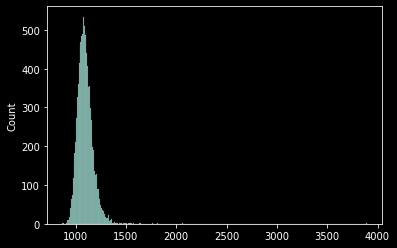

In [ ]:
sns.histplot(t)

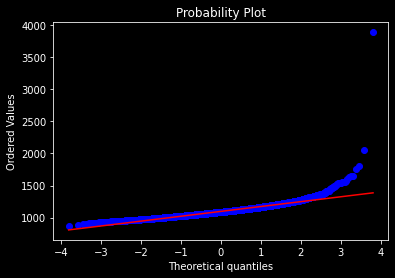

In [ ]:
# распределение похоже на нормальное, но это не так - у него тяжелый правый хвост
stats.probplot(t, dist='norm', plot=pylab)
pylab.show()

In [ ]:
'''
Здесь мы видим, что выброчное среднее распределено не нормально, следовательно,
усовие лдя проведения T-testa не выполняется. И для детектирования разницы между выборками
a = np.random.lognormal(mean=5, sigma=2, size=(10000,))
b = np.random.lognormal(mean=5.04, sigma=2, size=(10000,))
T-test применяться не может
''';

In [ ]:
# проверим это еще раз на одинаковых выборках (А/А тест)
result = []
n = 1000

for _ in tqdm(range(n)):
  a = np.random.lognormal(mean=5, sigma=2, size=(10000,))
  b = np.random.lognormal(mean=5, sigma=2, size=(10000,))  
  _, pval = ttest_ind(a,b,equal_var=False)
  result.append(pval)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
t = pd.Series(result)

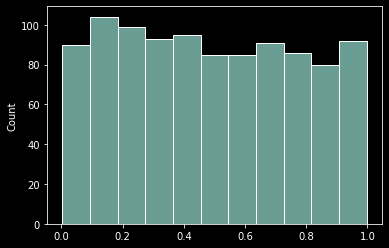

In [ ]:
sns.histplot(t)

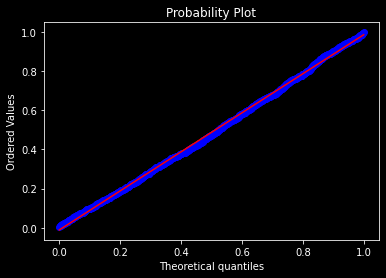

In [ ]:
stats.probplot(t, dist='uniform', plot=pylab)
pylab.show()

In [ ]:
# видим, что распределение p_value - равномерное

In [ ]:
# проверим ошибку первого рода
(t < 0.05).mean()

0.045

In [ ]:
# на А/А тесте кажется, что T-test можно провести.
# Посмотрим, получится ли у нас заданная мощность
# проверим это еще раз на одинаковых выборках (А/А тест)
result = []
n = 1000

for _ in tqdm(range(n)):
  a = np.random.lognormal(mean=5, sigma=2, size=(10000,))
  b = np.random.lognormal(mean=5.04, sigma=2, size=(10000,))  
  _, pval = ttest_ind(a,b,equal_var=False)
  result.append(pval)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
t = pd.Series(result)

In [ ]:
(t < 0.05).mean()

0.067

In [ ]:
# но НЕТ! заданная мощность на выборке такого размера не достигается,
# даже не смотря на то, что assumption о том, что p_value распределен равномерно - выполняется, 
# и даже альфа получается 0,05

In [ ]:
# Посчитаем теперь это математически

# оценка истинного среднего для выборки А на бутстрапе
a_mean_bs = pd.Series([np.random.lognormal(mean=5, sigma=2, size=(10000,)).mean() for _ in range(10000)]).mean()

# оценка истинного среднего для выборки В на бутстрапе
b_mean_bs = pd.Series([np.random.lognormal(mean=5.04, sigma=2, size=(10000,)).mean() for _ in range(10000)]).mean()

In [ ]:
a_mean_bs

1096.6305437448289

In [ ]:
b_mean_bs

1142.1965557256046

In [ ]:
# Истинные оценки среднего по формуле
a_mean = np.exp(5 + (2**2)/2)
b_mean = np.exp(5.04 + (2**2)/2)

In [ ]:
a_mean

1096.6331584284585

In [ ]:
b_mean # видим, что очень близко

1141.387606628968

In [ ]:
a.std()

5448.904216879781

In [ ]:
# стандартное отклонение логнормального распределения
variation_a = (np.exp(2**2) - 1) * np.exp(2*5 + (2**2))
std_a = np.sqrt(variation_a)
std_a

8028.534415020324

In [ ]:
variation_b = (np.exp(2**2) - 1) * np.exp(2*5.04 + (2**2))
std_b = np.sqrt(variation_b)
std_b

8356.185120127535

In [ ]:
es = (b_mean - a_mean) / std_a

In [ ]:
es

0.005574423162063022

In [ ]:
sms.TTestIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1)

505170.0230349757

In [ ]:
# чтобы мощность была 80% нужно вот столько наблюдений

In [ ]:
# теперь с этим размером выборки можно набутстрапить
t = pd.Series([np.random.lognormal(mean=5, sigma=2, size=(505170,)).mean() for _ in tqdm(range(1000))])


  0%|          | 0/1000 [00:00<?, ?it/s]

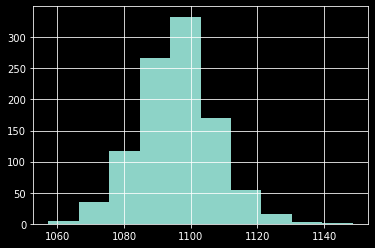

In [ ]:
t.hist() # видим перекошенный график

In [ ]:
# попробуем получить мощность 80% на найденном объеме выборки
result = []
n = 1000

for _ in tqdm(range(n)):
  a = np.random.lognormal(mean=5, sigma=2, size=(505170,))
  b = np.random.lognormal(mean=5.04, sigma=2, size=(505170,))  
  _, pval = ttest_ind(a,b,equal_var=False)
  result.append(pval)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
t = pd.Series(result)

In [ ]:
(t < 0.05).mean() # и получаем 0,8

0.811

In [ ]:
# Но поскольку выборочное среднее распределено не нормально, T-test использовать нельзя

Сделаем трансформацию выборок через логарифм

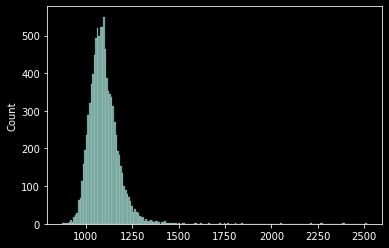

In [ ]:
# вот так распределена выборка А
t = [(np.random.lognormal(mean=5, sigma=2, size=(10000,))).mean() for _ in range(10000)]
sns.histplot(t)


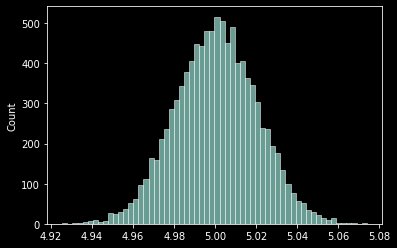

In [ ]:
# а вот так логарифмированная А
t = [np.log((np.random.lognormal(mean=5, sigma=2, size=(10000,)))).mean() for _ in range(10000)]
sns.histplot(t)

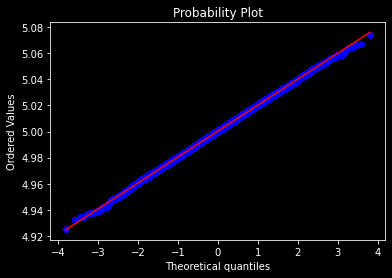

In [ ]:
stats.probplot(t, dist='norm', plot=pylab)
pylab.show()
# намного ближе к нормальному

In [ ]:
# будем логарифмировать А и В
result = []
n = 1000

for _ in tqdm(range(n)):
  a = np.log(np.random.lognormal(mean=5, sigma=2, size=(100000,)))
  b = np.log(np.random.lognormal(mean=5.04, sigma=2, size=(100000,)))
  _, pval = ttest_ind(a,b,equal_var=False)
  result.append(pval)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
t = pd.Series(result)

In [ ]:
(t < 0.05).mean() # получаем мощность даже с запасом

0.994

In [ ]:
# рассчитаем размеры выборок, которые нам нужны при логарифмировании
a = np.random.lognormal(mean=5, sigma=2, size=(100000,))

In [ ]:
es = (np.log(b_mean) - np.log(a_mean)) / np.log(a).std()

In [ ]:
es

0.01987880296090141

In [ ]:
sms.TTestIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1)

39725.25140797185

In [ ]:
# чтобы получить мощность 80% на логарифмированной выборке, нам нужно всего 39337 наблюдений
# проверим

result = []
n = 1000

for _ in tqdm(range(n)):
  a = np.log(np.random.lognormal(mean=5, sigma=2, size=(39337,)))
  b = np.log(np.random.lognormal(mean=5.04, sigma=2, size=(39337,)))
  _, pval = ttest_ind(a,b,equal_var=False)
  result.append(pval)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
t = pd.Series(result)

In [ ]:
(t < 0.05).mean() # получаем мощность даже с запасом

0.806

Логарифмирование - это МЕТОД ПОНИЖЕНИЯ ДИСПЕРСИИ

# Подбор лучшего распределения для неизвестного примера

In [ ]:
# Возьмем датасет про детей и зарплаты
! gdown --id 1zLKWeJ_OZjxuKlP561-GopniC0_Pt_X6

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1zLKWeJ_OZjxuKlP561-GopniC0_Pt_X6
To: /content/age_children_income_1000.csv
100% 38.8k/38.8k [00:00<00:00, 46.5MB/s]


In [ ]:
df = pd.read_csv('/content/age_children_income_1000.csv')

In [ ]:
df

,age,number_of_children,income
0,42.772420,0,34396.537188
1,29.561090,0,183350.052521
2,54.380735,0,53689.856555
3,42.551689,0,109080.913926
4,38.713080,0,153612.343419
...,...,...,...
995,36.281055,0,128647.922872
996,18.472716,0,67204.531673
997,40.547748,0,139432.757984
998,24.791760,1,137526.452334


In [ ]:
# Проведем  A/B тест по 'income'
df['income'].mean()

129415.74637843431

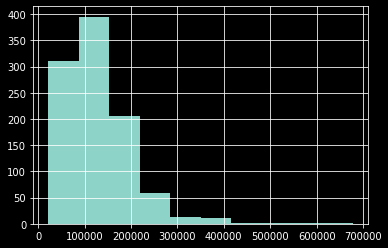

In [ ]:
df['income'].hist()

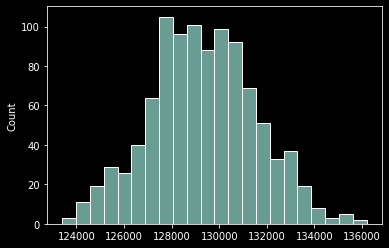

In [ ]:
# проверим, подойдет ли T-test
# забутстрапим income
# посмотрим как распределены выборочные средние

sns.histplot([df['income'].sample(1000, replace=True).mean() for _ in range(1000)])

In [ ]:
t = [df['income'].sample(1000, replace=True).mean() for _ in range(10000)]

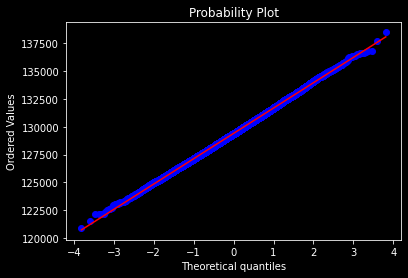

In [ ]:
stats.probplot(t, dist='norm', plot=pylab) # что с ч/ем сравниваем (t c 'norm')
pylab.show()

In [ ]:
# вывод: мы можем применить T-test

# Предпоожим, что мы хотим опредетять, что средний доход по выборке увеличился на 20000
# Рассчитаем, сколько нам нужно сэмплов, чтобы это задетектить

es = (150000 - 130000) / df['income'].std()
es

0.2806953684356604

In [ ]:
# вот такой нужен размер выборки
sms.TTestIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1)

200.20012721743498

In [ ]:
'''
Но как это проверить?
Как сгенерировать такое же распределение, но со средней зп = 150000
Для этого нужно подобрать максимально близкое к 'income' распределение (=с наименьшей ошибкой)
''';

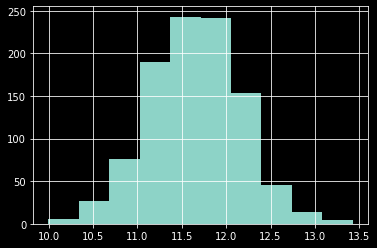

In [ ]:
# Вариант 1 - залогарифмировать
np.log(df['income']).hist()

In [ ]:
# Вариант 2 - подобрать распределение

# FIT DATA TO DISTRIBUTION

  1 / 104: ksone
  2 / 104: kstwo
  3 / 104: kstwobign
  4 / 104: norm
  5 / 104: alpha
  6 / 104: anglit
  7 / 104: arcsine
  8 / 104: beta
  9 / 104: betaprime
 10 / 104: bradford
 11 / 104: burr
 12 / 104: burr12
 13 / 104: fisk
 14 / 104: cauchy
 15 / 104: chi
 16 / 104: chi2
 17 / 104: cosine
 18 / 104: dgamma
 19 / 104: dweibull
 20 / 104: expon
 21 / 104: exponnorm
 22 / 104: exponweib
 23 / 104: exponpow
 24 / 104: fatiguelife
 25 / 104: foldcauchy
 26 / 104: f
 27 / 104: foldnorm
 28 / 104: weibull_min
 29 / 104: weibull_max
 30 / 104: genlogistic
 31 / 104: genpareto
 32 / 104: genexpon
 33 / 104: genextreme
 34 / 104: gamma
 35 / 104: erlang
 36 / 104: gengamma
 37 / 104: genhalflogistic
 38 / 104: genhyperbolic
 39 / 104: gompertz
 40 / 104: gumbel_r
 41 / 104: gumbel_l
 42 / 104: halfcauchy
 43 / 104: halflogistic
 44 / 104: halfnorm
 45 / 104: hypsecant
 46 / 104: gausshyper
 47 / 104: invgamma
 48 / 104: invgauss
 49 / 104: geninvgauss
 50 / 104: norminvgauss
 51 / 104: 

Text(0, 0.5, 'Frequency')

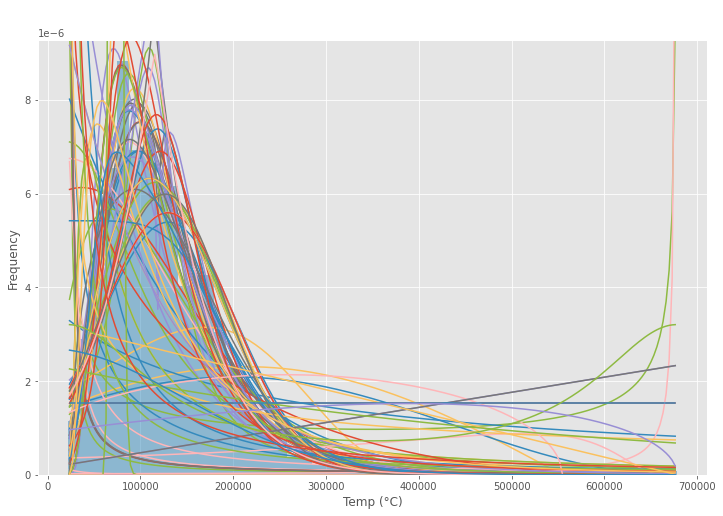

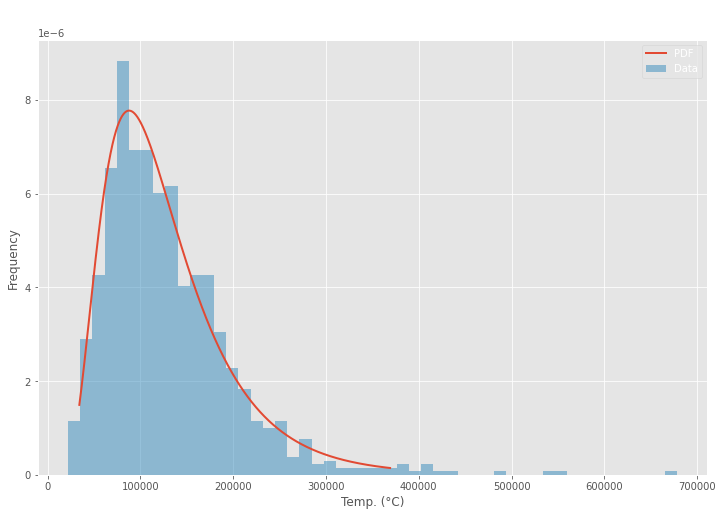

In [ ]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = df['income'] # -------> ПОДСТАВЛЯЕМ СВОЙ СТОЛБЕЦ

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

In [ ]:
# Посмотрим что это за распределение
t = pd.DataFrame(best_distibutions).sort_values(2)

In [ ]:
t

,0,1,2
0,<scipy.stats._continuous_distns.johnsonsb_gen ...,"(8.635547387774977, 1.940117105713055, -622.73...",1.079567e-10
1,<scipy.stats._continuous_distns.johnsonsu_gen ...,"(-6.485501433946867, 1.9829269046225697, -951....",1.080420e-10
2,<scipy.stats._continuous_distns.moyal_gen obje...,"(89998.53204903823, 30662.92827229847)",1.087651e-10
3,<scipy.stats._continuous_distns.invgamma_gen o...,"(7.379977853284383, -37236.18767801169, 106378...",1.094373e-10
4,<scipy.stats._continuous_distns.pearson3_gen o...,"(1.22551483493373, 129415.742690079, 67102.026...",1.110460e-10
...,...,...,...
90,<scipy.stats._continuous_distns.powerlognorm_g...,"(0.003741198473964768, 0.31146674447282985, 21...",5.363231e-09
99,<scipy.stats._continuous_distns.recipinvgauss_...,"(0.019883057522424048, 45284.73695771884, 539....",1.963693e-08
100,<scipy.stats._continuous_distns.vonmises_gen o...,"(1.825310157070612, 75185.7796536963, 3.223482...",9.731764e+45
88,<scipy.stats._continuous_distns.mielke_gen obj...,"(1009.044467627845, 1.951757980729706, -15.043...",NaN


In [ ]:
t[0][0] # вот оно

In [ ]:
t[1][0] # его параметры

(8.635547387774977, 1.940117105713055, -622.7363950863808, 9922160.800678246)

In [ ]:
# Теперь можно генерировать выборки такого распределения в будущем

Всегда можно использовать Манна-Уитни, но чтобы планировать эксперимент, лучше набутстрапить размер выборки для планирования эксперимента

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('dark_background')

In [ ]:
from scipy.stats import mannwhitneyu

In [ ]:
# можно и без логарифмирования
result = []
n = 100

for _ in tqdm(range(n)):
  a = np.random.lognormal(mean=5, sigma=2, size=(50000,))
  b = np.random.lognormal(mean=5.04, sigma=2, size=(50000,))
  _, pval = mannwhitneyu(a,b,alternative='two-sided')
  result.append(pval)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
t = pd.Series(result)

In [ ]:
(t < 0.05).mean() # получаем мощность

0.83

In [ ]:
# сразу проверим на пригодность Манна-Уитни на равномерное распределение p_value 
# и ошибку первого рода
result = []
n = 100

for _ in tqdm(range(n)):
  a = np.log(np.random.lognormal(mean=5, sigma=2, size=(100000,)))
  b = np.log(np.random.lognormal(mean=5, sigma=2, size=(100000,)))
  _, pval = mannwhitneyu(a,b,alternative='two-sided')
  result.append(pval)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
t = pd.Series(result)

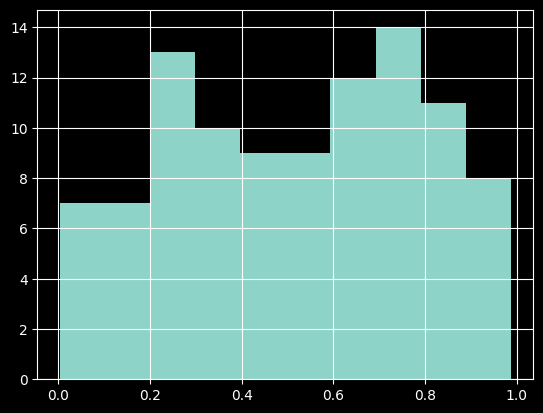

In [ ]:
t.hist()

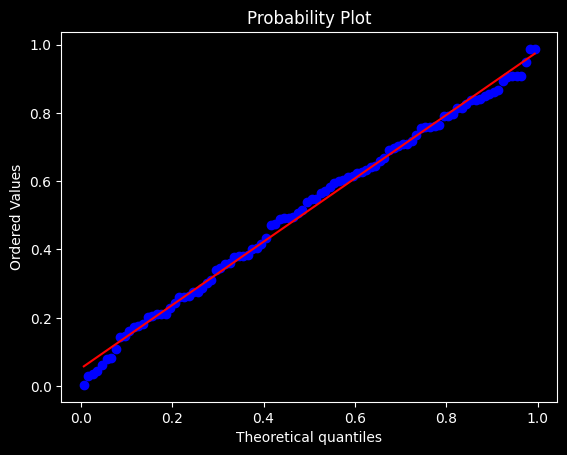

In [ ]:
stats.probplot(t, dist='uniform', plot=pylab) 
pylab.show()

In [ ]:
(t < 0.05).mean() # получаем ошибку первого рода

0.04